In [1]:
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import nltk.sentiment
from wordcloud import WordCloud

import acquire
import prepare

from env import user, password, host

# set up some basic matplotlib style parameters
plt.rc('figure', figsize=(12, 7))
plt.style.use('seaborn-darkgrid')


### 1.) Spam Data:

#### a.) Load the spam data set...

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()


,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### b.) Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [3]:
additional_stopwords = ['r', 'u', '2', 'ltgt']

def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^\w\s]", '', text)


In [4]:
# Combine all messages in single string by label

ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [5]:
# Splitting the entire sub-corpus of total words in a class type by spaces,
# Turning the list output by split into a Series, then getting that value_counts()
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq =pd.Series(all_words.split()).value_counts()

In [6]:
ham_freq

i                                            2188
you                                          1837
to                                           1554
the                                          1118
a                                            1055
u                                             972
and                                           848
in                                            811
me                                            756
my                                            743
is                                            728
it                                            590
of                                            524
for                                           501
that                                          486
im                                            449
have                                          438
but                                           418
your                                          414
so                                            412


In [7]:
# Concat all frequencies together into a dataframe
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']

In [8]:
word_counts.head(3)

,ham,spam,all
i,2188,45,2233
you,1837,287,2124
to,1554,686,2240


In [9]:
# Sort by 'all'

word_counts.sort_values('all', ascending=False).head(10)

,ham,spam,all
to,1554,686,2240
i,2188,45,2233
you,1837,287,2124
a,1055,376,1431
the,1118,204,1322
u,972,147,1119
and,848,122,970
is,728,158,886
in,811,73,884
me,756,30,786


Text(0.5, 1.0, 'Ham vs Spam Count for top 10 Most Frequent Overall Words')

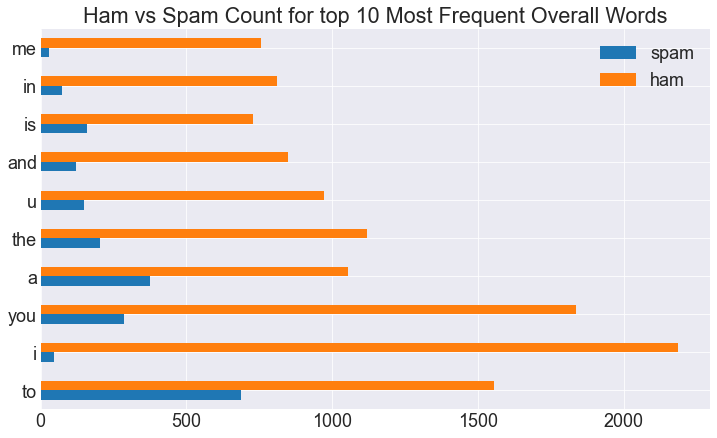

In [10]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(10)[['spam', 'ham']].plot.barh()
plt.title('Ham vs Spam Count for top 10 Most Frequent Overall Words')

Text(0.5, 1.0, 'Ham vs Spam Top 10 Words Proportions')

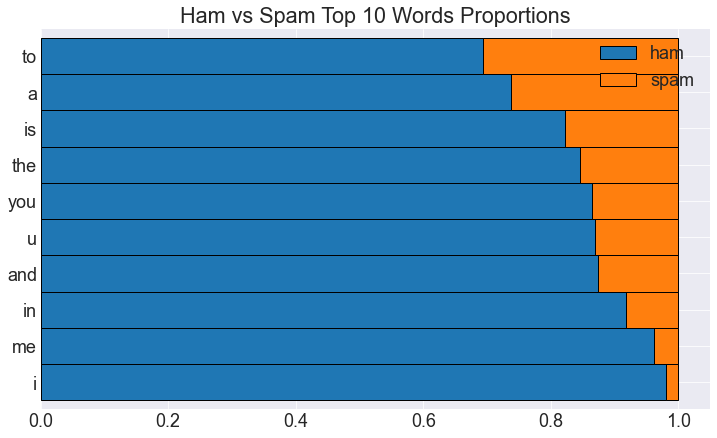

In [11]:

(word_counts.sort_values('all', ascending=False)
 .head(10)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all').
 sort_values('spam')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('Ham vs Spam Top 10 Words Proportions')

### n-grams...

In [12]:
# us 
bigrams = nltk.ngrams(all_words.split(), 2)
list(bigrams)

[('go', 'until'),
 ('until', 'jurong'),
 ('jurong', 'point'),
 ('point', 'crazy'),
 ('crazy', 'available'),
 ('available', 'only'),
 ('only', 'in'),
 ('in', 'bugis'),
 ('bugis', 'n'),
 ('n', 'great'),
 ('great', 'world'),
 ('world', 'la'),
 ('la', 'e'),
 ('e', 'buffet'),
 ('buffet', 'cine'),
 ('cine', 'there'),
 ('there', 'got'),
 ('got', 'amore'),
 ('amore', 'wat'),
 ('wat', 'ok'),
 ('ok', 'lar'),
 ('lar', 'joking'),
 ('joking', 'wif'),
 ('wif', 'u'),
 ('u', 'oni'),
 ('oni', 'free'),
 ('free', 'entry'),
 ('entry', 'in'),
 ('in', '2'),
 ('2', 'a'),
 ('a', 'wkly'),
 ('wkly', 'comp'),
 ('comp', 'to'),
 ('to', 'win'),
 ('win', 'fa'),
 ('fa', 'cup'),
 ('cup', 'final'),
 ('final', 'tkts'),
 ('tkts', '21st'),
 ('21st', 'may'),
 ('may', '2005'),
 ('2005', 'text'),
 ('text', 'fa'),
 ('fa', 'to'),
 ('to', '87121'),
 ('87121', 'to'),
 ('to', 'receive'),
 ('receive', 'entry'),
 ('entry', 'questionstd'),
 ('questionstd', 'txt'),
 ('txt', 'ratetcs'),
 ('ratetcs', 'apply'),
 ('apply', '08452810075ov

Find the most common bigram and then find a representative text



Text(0.5, 1.0, 'Ten Most Common Bigrams Overall')

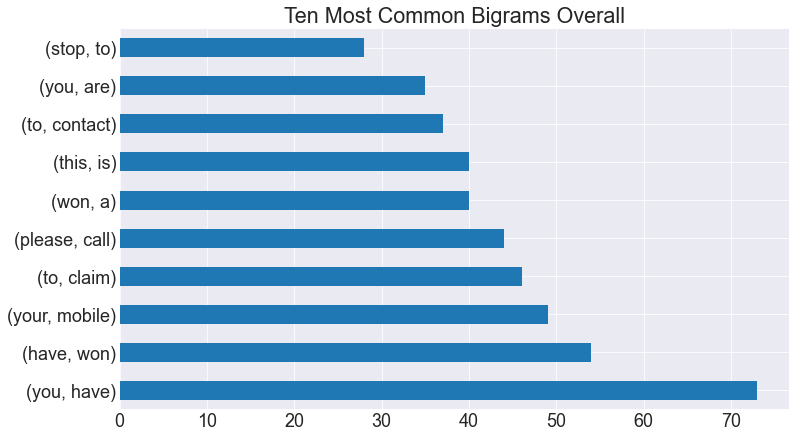

In [13]:
pd.Series(nltk.bigrams(spam_words.split())).value_counts().head(10).plot.barh()
plt.title('Ten Most Common Bigrams Overall')

(-0.5, 799.5, 599.5, -0.5)

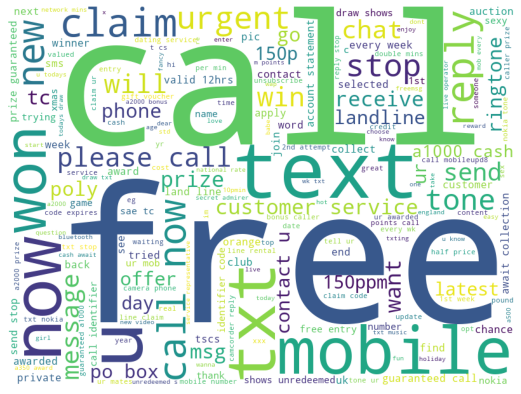

In [14]:
from wordcloud import WordCloud

# WordCloud for spam words...
img = WordCloud(background_color='white', width=800, height=600).generate(spam_words)
plt.imshow(img)
plt.axis('off')


(-0.5, 799.5, 599.5, -0.5)

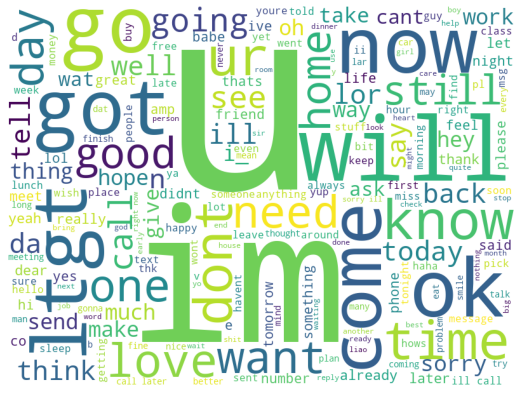

In [15]:
# WordCloud for ham words...
img = WordCloud(background_color='white', width=800, height=600).generate(ham_words)
plt.imshow(img)
plt.axis('off')

### 2.) Codeup Blog Data:

In [16]:
codeup = acquire.get_codeup_articles()
codeup.head(2)

,title,published,content
0,Learn to Code: Python Workshop on 4/23,"Mar 31, 2022","According to LinkedIn, the “#1 Most Promising ..."
1,Coming Soon: Cloud Administration,"Mar 17, 2022",We’re launching a new program out of San Anton...


In [17]:
# Sentiment Analysis of Codeup Blog Articles.

In [18]:
import nltk.sentiment

sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [19]:
sia.polarity_scores(codeup.content[0])

{'neg': 0.03, 'neu': 0.796, 'pos': 0.174, 'compound': 0.9817}

In [20]:
codeup['blog_length'] = codeup.content.apply(len)

codeup['word_count'] = codeup.content.apply(clean).apply(str.split).apply(len)

codeup['sentiment'] = codeup.content.apply(lambda content: sia.polarity_scores(content)['compound'])

In [21]:
codeup.head()

,title,published,content,blog_length,word_count,sentiment
0,Learn to Code: Python Workshop on 4/23,"Mar 31, 2022","According to LinkedIn, the “#1 Most Promising ...",829,151,0.9817
1,Coming Soon: Cloud Administration,"Mar 17, 2022",We’re launching a new program out of San Anton...,2289,358,0.9835
2,5 Books Every Woman In Tech Should Read,"Mar 8, 2022",On this International Women’s Day 2022 we want...,6548,1074,0.9455
3,Codeup Start Dates for March 2022,"Jan 26, 2022",As we approach the end of January we wanted to...,1832,317,0.9831
4,VET TEC Funding Now Available For Dallas Veterans,"Jan 7, 2022",We are so happy to announce that VET TEC benef...,2143,378,0.9916


### 2b.) InShorts Data:

In [22]:
InShorts = acquire.get_inshorts_articles()

Getting articles for business
Getting articles for sports
Getting articles for entertainment
Getting articles for technology


In [24]:
# Sentiment Analysis of InShorts Articles...

InShorts['blog_length'] = InShorts.content.apply(len)
InShorts['word_count'] = InShorts.content.apply(clean).apply(str.split).apply(len)
InShorts['sentiment'] = InShorts.content.apply(lambda content: sia.polarity_scores(content)['compound'])

In [25]:
InShorts.head()

,category,title,content,author,published,blog_length,word_count,sentiment
0,business,India's retail inflation surges to 7.79% in Ap...,India's retail inflation surged to 7.79% in Ap...,Pragya Swastik,2022-05-12T12:41:14.000Z,399,66,0.0772
1,business,"Rupee hits new all-time low, slips to 77.55 ag...",The Indian rupee has touched a fresh all-time ...,Apaar Sharma,2022-05-12T05:58:52.000Z,423,69,-0.5423
2,business,List of 10 highest-paid sportspersons released...,Argentina and PSG forward Lionel Messi was the...,Anmol Sharma,2022-05-12T05:22:54.000Z,366,60,0.0000
3,business,Saudi Aramco dethrones Apple as world's most v...,World's biggest crude exporter Saudi Aramco ha...,Anmol Sharma,2022-05-12T05:40:33.000Z,395,62,0.4754
4,business,Over $200 billion wiped off cryptocurrency mar...,More than $200 billion of wealth was wiped out...,Pragya Swastik,2022-05-12T12:19:46.000Z,415,69,-0.4939


In [29]:
codeup.sentiment.median(), InShorts.sentiment.median()

(0.9831, 0.24975)

### 3.) Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.